In [ ]:
pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper

Obtaining bq_helper from git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper
  Updating ./src/bq-helper clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f
  Found existing installation: bq-helper 0.4.1
    Can't uninstall 'bq-helper'. No files were found to uninstall.
  Running setup.py develop for bq-helper


In [ ]:
pip install --upgrade google-cloud-bigquery

Requirement already up-to-date: google-cloud-bigquery in /usr/local/lib/python3.6/dist-packages (2.4.0)


In [ ]:
pip install hashlib

  Using cached https://files.pythonhosted.org/packages/74/bb/9003d081345e9f0451884146e9ea2cff6e4cc4deac9ffd4a9ee98b318a49/hashlib-20081119.zip
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
pip install base58check

In [ ]:
pip install squarify

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from bq_helper import BigQueryHelper
import squarify
import time
import gc
import re
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="BigQuery-credentials.json"

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account

# TODO(developer): Set key_path to the path to the service account key
#                  file.
key_path = "BigQuery-credentials.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

In [ ]:
bq_assistant = BigQueryHelper('bigquery-public-data','bitcoin_blockchain',max_wait_seconds=6000)
bq_assistant.list_tables()

['blocks', 'transactions']

In [ ]:
n=5000
A=bq_assistant.head("transactions", num_rows=n)
A.head()

,timestamp,transaction_id,inputs,outputs,block_id,previous_block,merkle_root,nonce,version,work_terahash,work_error
0,1241693386000,b78dd4052c5c19ed15bff7f7cbc072cb87601680165412...,[{'input_script_bytes': b'\x04\xff\xff\x00\x1d...,"[{'output_satoshis': 5000000000, 'output_scrip...",000000006b6810ea2b71871065c31f0939c61bc73ca19e...,000000009f9639803e3a9424f210004c25c2c2e6a85836...,b78dd4052c5c19ed15bff7f7cbc072cb87601680165412...,3796474150,1,0,None
1,1261947871000,bfcb4467092290da3bee702d5ffedfe1933c36a18b0e77...,[{'input_script_bytes': b'\x04\xff\xff\x00\x1d...,"[{'output_satoshis': 5000000000, 'output_scrip...",000000003d0aa75d182618516bf64536d94119d23ef412...,00000000c1405320b87082391bd82155d88728dea85cd6...,bfcb4467092290da3bee702d5ffedfe1933c36a18b0e77...,296968200,1,0,None
2,1262072718000,a069017c031239357a6d325c7a10e6f4ed7cb722b1cb38...,[{'input_script_bytes': b'\x04\xff\xff\x00\x1d...,"[{'output_satoshis': 5000000000, 'output_scrip...",00000000b574d15c470a479874f19ea232b8b26e3ab742...,00000000adfab959a70c842627272d1ab2124d5ced5e2b...,a069017c031239357a6d325c7a10e6f4ed7cb722b1cb38...,132461744,1,0,None
3,1261474382000,9b9d3a70b70df897e2383fe16a09286502222f7ca06653...,[{'input_script_bytes': b'\x04\xff\xff\x00\x1d...,"[{'output_satoshis': 5000000000, 'output_scrip...",000000006224e9ce1dbe8a9b593d8f0485a19983b479bd...,00000000833508fb6be4b80e977e3eaa04994353b81cb3...,9b9d3a70b70df897e2383fe16a09286502222f7ca06653...,40052755,1,0,None
4,1277392209000,3fe2d7fa73e776f591e075783bc24cbd3e2fff8d444c72...,[{'input_script_bytes': b'\x04B1\r\x1c\x02\r\x...,"[{'output_satoshis': 5000000000, 'output_scrip...",0000000001ad7196de0396085a3fa95f2322722aa8b805...,000000000393cb2dc72fc296c66d9a19d2c01493e70c6d...,22d86d39b6d1226fbc372ce90f19e21c8b656ede4d8a8c...,90360458,1,0,None


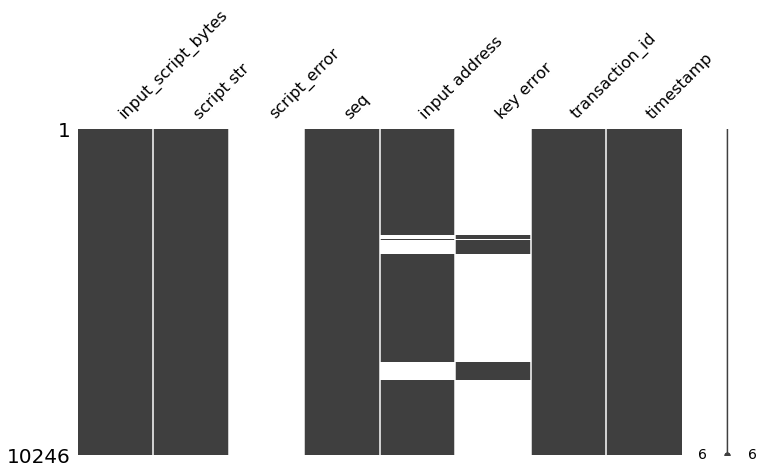

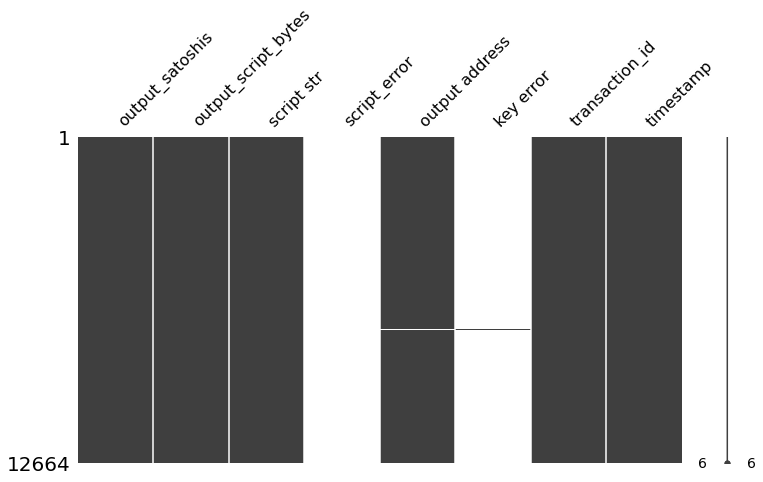

In [ ]:
display_dict={'input_pubkey_base58':'input address','input_pubkey_base58_error':'key error', 'input_script_byte': 'script byte','input_script_string': 'script str', 'input_script_string_error':'script_error','input_sequence_number':'seq','output_pubkey_base58':'output address','output_pubkey_base58_error':'key error', 'output_script_byte': 'script byte','output_script_string': 'script str', 'output_script_string_error':'script_error'}
inputs=(pd.concat([pd.DataFrame(data=A.inputs[i]).assign(transaction_id=A.transaction_id[i],timestamp=A.timestamp[i]) for i in range(len(A))])
                .reset_index(drop=True))
msno.matrix(inputs.rename(columns=display_dict),figsize=(12,6));
outputs=(pd.concat([pd.DataFrame(data=A.outputs[i]).assign(transaction_id=A.transaction_id[i],timestamp=A.timestamp[i]) for i in range(len(A))])
                .reset_index(drop=True))
msno.matrix(outputs.rename(columns=display_dict),figsize=(12,6));

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
import squarify
import operator
import time
import re
import gc
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

class MyBQHelper(object):
    """
    Helper class to simplify common BigQuery tasks like executing queries,
    showing table schemas, etc without worrying about table or dataset pointers.
    See the BigQuery docs for details of the steps this class lets you skip:
    https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/reference.html
    """

    BYTES_PER_GB = 2**30

    def __init__(self, active_project, dataset_name, max_wait_seconds=180):
        self.project_name = active_project
        self.dataset_name = dataset_name
        self.max_wait_seconds = max_wait_seconds
        self.client = bigquery.Client()
        self.__dataset_ref = self.client.dataset(self.dataset_name, project=self.project_name)
        self.dataset = None
        self.tables = dict()  # {table name (str): table object}
        self.__table_refs = dict()  # {table name (str): table reference}
        self.total_gb_used_net_cache = 0

    def __fetch_dataset(self):
        # Lazy loading of dataset. For example,
        # if the user only calls `self.query_to_pandas` then the
        # dataset never has to be fetched.
        if self.dataset is None:
            self.dataset = self.client.get_dataset(self.__dataset_ref)

    def __fetch_table(self, table_name):
        # Lazy loading of table
        self.__fetch_dataset()
        if table_name not in self.__table_refs:
            self.__table_refs[table_name] = self.dataset.table(table_name)
        if table_name not in self.tables:
            self.tables[table_name] = self.client.get_table(self.__table_refs[table_name])

    def table_schema(self, table_name):
        """
        Get the schema for a specific table from a dataset
        """
        self.__fetch_table(table_name)
        return(self.tables[table_name].schema)

    def list_tables(self):
        """
        List the names of the tables in a dataset
        """
        self.__fetch_dataset()
        return([x.table_id for x in self.client.list_tables(self.dataset)])

    def estimate_query_size(self, query):
        """
        Estimate gigabytes scanned by query.
        Does not consider if there is a cached query table.
        See https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs#configuration.dryRun
        """
        my_job_config = bigquery.job.QueryJobConfig()
        my_job_config.dry_run = True
        my_job = self.client.query(query, job_config=my_job_config)
        return my_job.total_bytes_processed / self.BYTES_PER_GB

    def query_to_pandas(self, query):
        """
        Take a SQL query & return a pandas dataframe
        """
        my_job = self.client.query(query)
        start_time = time.time()
        while not my_job.done():
            if (time.time() - start_time) > self.max_wait_seconds:
                print("Max wait time elapsed, query cancelled.")
                self.client.cancel_job(my_job.job_id)
                return None
            time.sleep(0.1)
        #print(my_job._properties.get('status'))
        if my_job.total_bytes_billed:
            self.total_gb_used_net_cache += my_job.total_bytes_billed / self.BYTES_PER_GB
        return my_job.to_dataframe()

    def query_to_pandas_safe(self, query, max_gb_scanned=1):
        """
        Execute a query if it's smaller than a certain number of gigabytes
        """
        query_size = self.estimate_query_size(query)
        if query_size <= max_gb_scanned:
            return self.query_to_pandas(query)
        msg = "Query cancelled; estimated size of {0} exceeds limit of {1} GB"
        print(msg.format(query_size, max_gb_scanned))

    def head(self, table_name, num_rows=5, start_index=None, selected_columns=None):
        """
        Get the first n rows of a table as a DataFrame
        """
        self.__fetch_table(table_name)
        active_table = self.tables[table_name]
        schema_subset = None
        if selected_columns:
            schema_subset = [col for col in active_table.schema if col.name in selected_columns]
        results = self.client.list_rows(active_table, selected_fields=schema_subset,
            max_results=num_rows, start_index=start_index)
        results = [x for x in results]
        return pd.DataFrame(
            data=[list(x.values()) for x in results], columns=list(results[0].keys()))
    
    
from base58check import b58encode
from hashlib import sha256
from hashlib import new as hnew

def pubkey_to_hash(pubkey_string):
    hash_160=hnew('ripemd160')
    hash_160.update(sha256(bytes.fromhex(pubkey_string)).digest())
    return hash_160.hexdigest()

def address_from_hash(hash_string,pubkey=True):
    prefix='00' if pubkey else '05'
    PubKeyHash=bytes.fromhex(prefix+hash_string)
    checksum=sha256(sha256(PubKeyHash).digest()).digest()[:4]
    haa=PubKeyHash+checksum
    return b58encode(haa).decode('utf-8')

def address_from_pubkey(pubkey_string,pubkey=True):
    return address_from_hash(pubkey_to_hash(pubkey_string),pubkey)
    
bq_assistant = MyBQHelper('bigquery-public-data','bitcoin_blockchain',max_wait_seconds=6000)

In [ ]:
pip install pyarrow==2.0.0

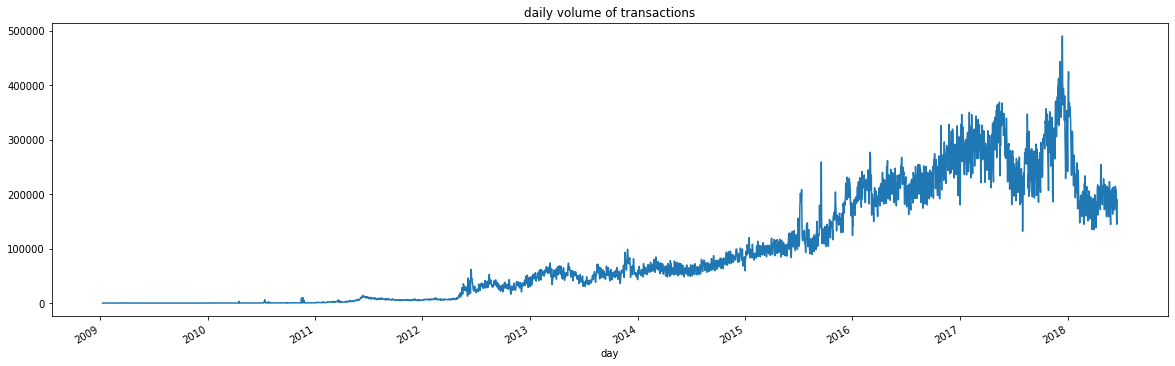

In [ ]:
QUERY='''
#standardSQL
SELECT TIMESTAMP_MILLIS((timestamp - MOD(timestamp,86400000))) AS day, COUNT(DISTINCT transaction_id) as volume
FROM `bigquery-public-data.bitcoin_blockchain.transactions`
WHERE timestamp<1529363632000
GROUP BY day
'''
daily_volume=bq_assistant.query_to_pandas(QUERY)
daily_volume.set_index('day').volume.plot(title='daily volume of transactions',figsize=(20,6));


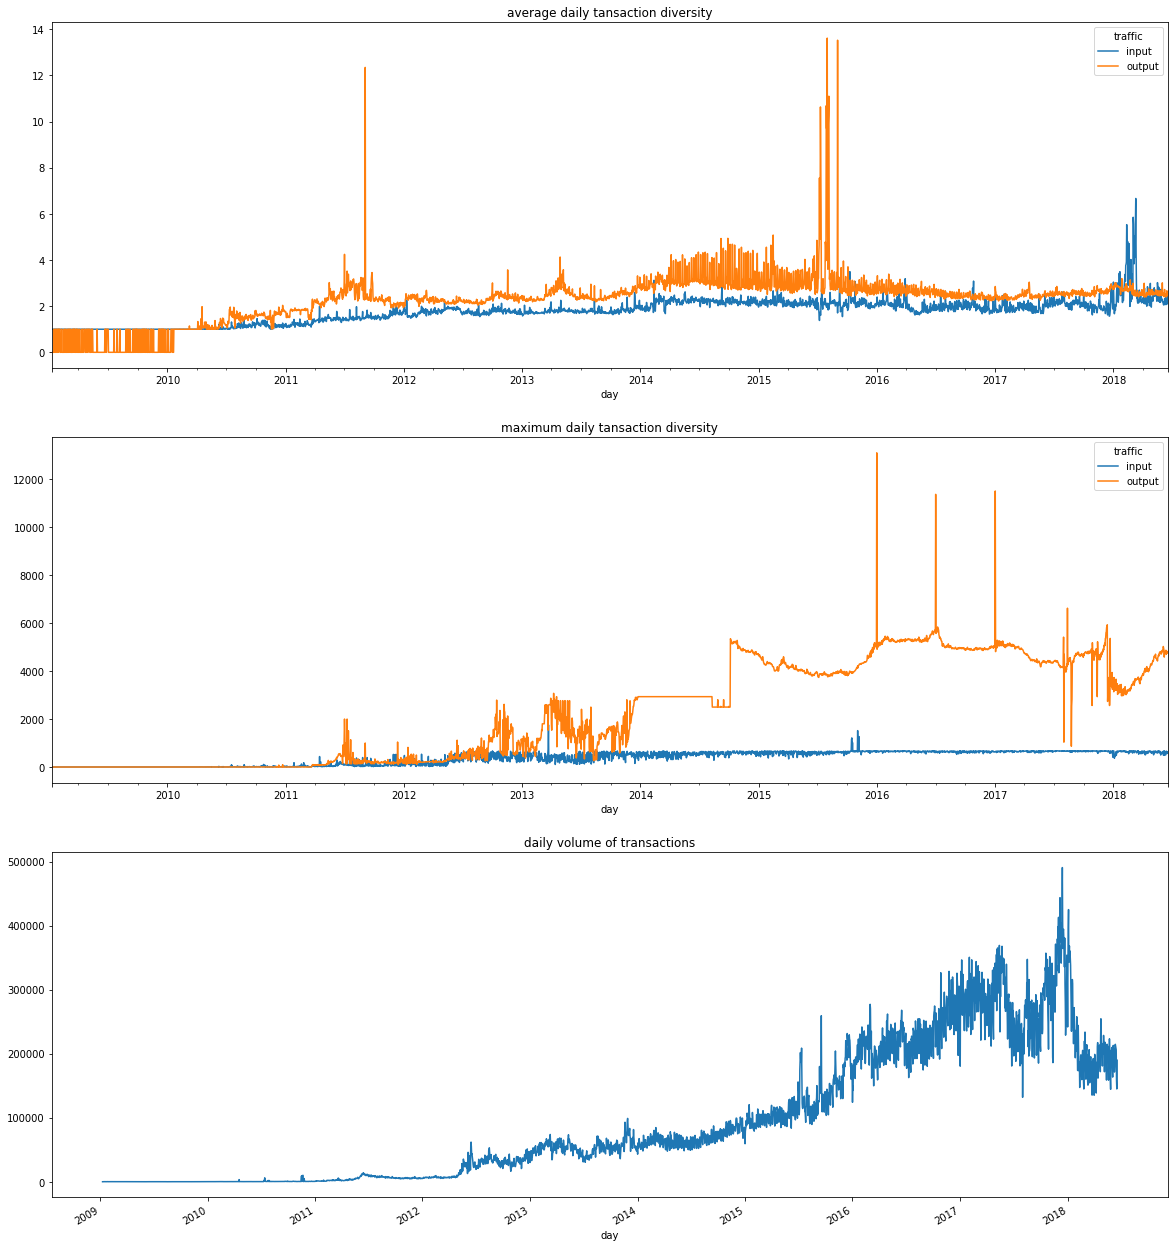

In [ ]:
QUERY='''
#standardSQL
WITH transaction_traffic AS (
                     (SELECT TIMESTAMP_MILLIS((timestamp - MOD(timestamp,86400000))) AS day, 'input' as traffic, COUNT(DISTINCT i.input_pubkey_base58) AS count
                      FROM `bigquery-public-data.bitcoin_blockchain.transactions`, UNNEST(inputs) AS i
                      WHERE (i.input_pubkey_base58 IS NOT NULL) AND (timestamp<1529363632000)
                      GROUP BY day,transaction_id)
                     UNION ALL
                     (SELECT TIMESTAMP_MILLIS((timestamp - MOD(timestamp,86400000))) AS day, 'output' as traffic, COUNT(DISTINCT o.output_pubkey_base58) AS count
                      FROM `bigquery-public-data.bitcoin_blockchain.transactions`, UNNEST(outputs) AS o
                      WHERE (o.output_pubkey_base58 IS NOT NULL)  AND (timestamp<1529363632000)
                      GROUP BY day, transaction_id)
                      )
SELECT day, traffic, AVG(count) as average_count,MAX(count) as max_count,MIN(count) as min_count
FROM transaction_traffic
GROUP BY day,traffic
'''
daily_diversity=bq_assistant.query_to_pandas(QUERY)
fig,axes=plt.subplots(nrows=3,figsize=(20,24))
daily_diversity.set_index(['day','traffic'])['average_count'].unstack(level=1).fillna(0).plot(title='average daily tansaction diversity',ax=axes[0]);
daily_diversity.set_index(['day','traffic']).max_count.unstack(level=1).fillna(0).plot(title='maximum daily tansaction diversity',ax=axes[1]);
daily_volume.set_index('day').volume.plot(title='daily volume of transactions',ax=axes[2]);
#daily_diversity.set_index(['day','traffic']).min_count.unstack(level=1).fillna(0).plot(title='minimum daily tansaction diversity',ax=axes[2]);

# NEXT CHAPTER

In [ ]:
import pandas as pd
import hashlib
import os

class DataSaver:
    def __init__(self, bq_assistant):
        self.bq_assistant=bq_assistant
        
    def Run_Query(self, query, max_gb_scanned=1):
        hashed_query=''.join(query.split()).encode("ascii","ignore")
        query_hash=hashlib.md5(hashed_query).hexdigest()
        query_hash+=".csv"
        if query_hash in os.listdir(os.getcwd()):
            print ("Data Already present getting it from file")
            print (query_hash)
            return pd.read_csv(query_hash)
        else:
            data=self.bq_assistant.query_to_pandas_safe(query, max_gb_scanned=max_gb_scanned)
            data.to_csv(query_hash, index=False,encoding='utf-8')
            print (query_hash)
            return data

In [ ]:
# bq_assistant = BigQueryHelper("bigquery-public-data", "bitcoin_blockchain")

# bq=DataSaver(bq_assistant)




q = """
SELECT  o.output_pubkey_base58, sum(o.output_satoshis) as output_sum from 
    `bigquery-public-data.bitcoin_blockchain.transactions`JOIN
    UNNEST(outputs) as o 
    where o.output_pubkey_base58 not in (select i.input_pubkey_base58
    from UNNEST(inputs) as i)
    group by o.output_pubkey_base58 order by output_sum desc limit 1000
"""
print (str(round((bq_assistant.estimate_query_size(q)),2))+str(" GB"))

results2=bq.Run_Query(q, max_gb_scanned=70)
results2["output_sum"]=results2["output_sum"].apply(lambda x: float(x/100000000))


62.03 GB
Data Already present getting it from file
90d61c602b72f0ae37b17afd0660547a.csv


<BarContainer object of 1000 artists>

([<matplotlib.axis.XTick at 0x7fb190cac0f0>,
 [Text(0, 0, '1LNWw6yCxkUmkhArb2Nf2MPw6vG7u5WG7q'),
  Text(0, 0, '12cgpFdJViXbwHbhrA3TuW1EGnL25Zqc3P'),
  Text(0, 0, '3KgtbGgaX2ngstNpvyv7LwpHSweVeqGbpM'),
  Text(0, 0, '1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s'),
  Text(0, 0, '13p5iQkqBEVgKmPeJqEL2LBRS44PjX1dZL'),
  Text(0, 0, '1FXqE2ixnnSB1kvwbMtWma5xQ2bVbkSq3f'),
  Text(0, 0, '32MKGhKdTqEQZrrtd7iemEETz8bn7CJEaW'),
  Text(0, 0, '1Y2sKhUZvsP2EANpKra3FaFZufHq5VEwT'),
  Text(0, 0, '1GQmweAj7Lqwzs4eD8u6DjGA8da2kaG93S'),
  Text(0, 0, '1Po4J4SNyJuGnMGYJfGTXLEvGgAZKiddr7'),
  Text(0, 0, '14wXrm49HxggbdQ6RGfWY8qghGEWhLA28K'),
  Text(0, 0, '12ucu9bHLe2w2ahjibVtp3xmdcGkgUmX4A'),
  Text(0, 0, '1KumbRsTcA6UNqU2MHEfqEFnAZYU3w3izR'),
  Text(0, 0, '1MEe2mebed8wopvy8xyjjHcEQHUPVJn2UC'),
  Text(0, 0, '1Lsqcv4cg5zUctNi2qwNxMkrv1GeBboSUJ'),
  Text(0, 0, '1GUkazUBpXWdSJ9HbgTapAH7uybpi3Cs6K'),
  Text(0, 0, '1KYXrw4Ftkmomfs4iyVXUSqQeRX75Unoi8'),
  Text(0, 0, '17BymcHaGRbXGnEzR2m9woUYNf9FBPPJ2P'),
  Text(0, 0, '19iVyH

Text(0, 0.5, 'Bitcoins')

Text(0.5, 1.0, 'Bitcoins Addresses Who received Most number of bitcoins')

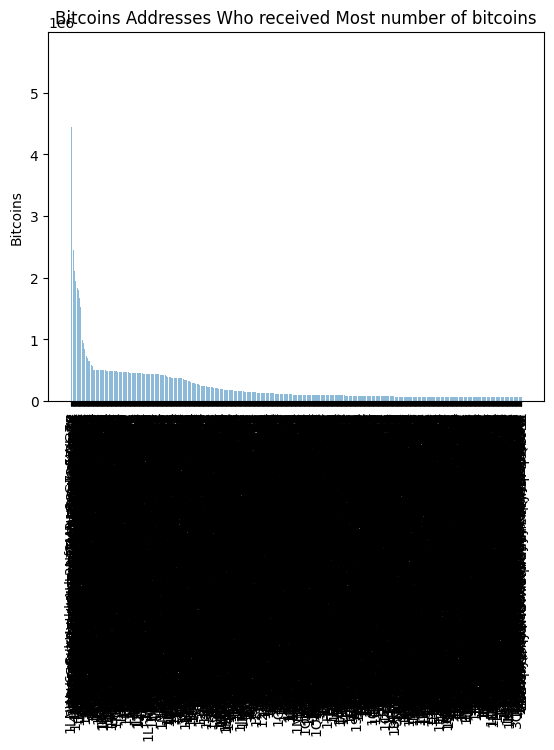

In [ ]:
#plotting the first 1000 of most funded bitcoin wallets as of yet



import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
objects = results2["output_pubkey_base58"][:1000]
y_pos = np.arange(len(objects))
performance = results2["output_sum"][:1000]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=90)
plt.ylabel('Bitcoins')
plt.title('Bitcoins Addresses Who received Most number of bitcoins')
plt.show()

In [ ]:
#The biggest transaction ever made on the bitcoin blockchain



q = """
SELECT  TIMESTAMP_MILLIS((timestamp - MOD(timestamp,
          86400000))) AS day,o.output_pubkey_base58, o.output_satoshis as output_max from 
    `bigquery-public-data.bitcoin_blockchain.transactions`JOIN
    UNNEST(outputs) as o order by output_max desc limit 1000
"""
print (str(round((bq_assistant.estimate_query_size(q)),2))+str(" GB"))
results3=bq.Run_Query(q, max_gb_scanned=56)

#CONVERT SATOSHIS TO BITCOINS
results3["output_max"]=results3["output_max"].apply(lambda x: float(x/100000000))
results3.head()

39.93 GB
Data Already present getting it from file
3116c8a61f8c9f40b8423ae985402c1e.csv


,day,output_pubkey_base58,output_max
0,2011-11-16 00:00:00+00:00,1M8s2S5bgAzSSzVTeL7zruvMPLvzSkEAuv,500000.000000
1,2011-11-16 00:00:00+00:00,1GmPZeLn93CJnu8r4hdeFfRtQyF3mXNRQy,499720.700177
2,2011-11-17 00:00:00+00:00,1Mb5rPL3zeHqx8rd5Xg9jkcxTKSMkKfktb,499643.982390
3,2011-11-17 00:00:00+00:00,1BdVGd582jsQYBeLYqtgyptxKifZAC4Zdx,499609.087390
4,2011-11-17 00:00:00+00:00,1AqaB54bqo2hqHxsYznpMVuknA9DB3agzK,499420.954750


In [ ]:
import plotly.graph_objects as go
import plotly as py


results4=results3.sort_values(by="day")
layout = go.Layout(title="Time Series of Highest single output transaction")
data = [go.Scatter(x=results4.day, y=results4.output_max)]
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [ ]:
print (results3.iloc[len(results3)-1]["output_max"])
print (results3.iloc[len(results3)-1]["day"])

50344.86623271
2012-09-19 00:00:00+00:00


In [ ]:
d=Counter(years_output_final)
d.most_common(1)
Create_Bar_plotly(d.most_common(), title="Single Highest Valued Transaction Average Per Year")

NameError: ignored

In [ ]:
q = """
SELECT  TIMESTAMP_MILLIS((timestamp - MOD(timestamp,
          86400000))) AS day, avg(o.output_satoshis) as output_avg from 
    `bigquery-public-data.bitcoin_blockchain.transactions`JOIN
    UNNEST(outputs) as o group by day order by output_avg desc
"""
print (str(round((bq_assistant.estimate_query_size(q)),2))+str(" GB"))

results5=bq.Run_Query(q, max_gb_scanned=89)

#CONVERT SATOSHIS TO BITCOINS
results5["output_avg"]=results5["output_avg"].apply(lambda x: float(x/100000000))
results5.head()

9.44 GB
451ec64f26a84095ce8f809c391e4f1f.csv


,day,output_avg
0,2009-11-11 00:00:00+00:00,1179.746835
1,2010-10-04 00:00:00+00:00,968.492938
2,2011-04-20 00:00:00+00:00,857.154013
3,2010-11-08 00:00:00+00:00,817.185701
4,2011-01-27 00:00:00+00:00,747.819239


In [ ]:
results6=results5.sort_values(by="day")
layout = go.Layout(title="Time Series of AVERAGE in no of bitcoins transacted per day")
data = [go.Scatter(x=results6.day, y=results6.output_avg)]
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [ ]:
q = """
SELECT  TIMESTAMP_MILLIS((timestamp - MOD(timestamp,
          86400000))) AS day, count(o.output_satoshis) as counts from 
    `bigquery-public-data.bitcoin_blockchain.transactions`JOIN
    UNNEST(outputs) as o group by day order by counts
"""
print (str(round((bq_assistant.estimate_query_size(q)),2))+str(" GB"))
results7=bq.Run_Query(q,max_gb_scanned=180)
results7.tail()

9.44 GB
f32995db459fdb2db113163aa9ac11cc.csv


,day,counts
3527,2015-07-08 00:00:00+00:00,1504764
3528,2015-07-29 00:00:00+00:00,1535909
3529,2015-07-31 00:00:00+00:00,1621968
3530,2015-08-01 00:00:00+00:00,1685670
3531,2015-09-02 00:00:00+00:00,2035035


In [ ]:
results7=results7.sort_values(by="day")
layout = go.Layout(title="Time Series of transaction COUNT in Bitcoins")
data = [go.Scatter(x=results7.day, y=results7.counts)]
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [ ]:
q = """
SELECT  TIMESTAMP_MILLIS((timestamp - MOD(timestamp,
          86400000))) as Timestamp, sum(o.output_satoshis) as output_price from 
    `bigquery-public-data.bitcoin_blockchain.transactions`JOIN
    UNNEST(outputs) as o group by timestamp
"""
print (str(round((bq_assistant.estimate_query_size(q)),2))+str(" GB"))
results3=bq_assistant.query_to_pandas(q)
results3["output_price"]=results3["output_price"].apply(lambda x: float(x/100000000))
results3=results3.sort_values(by="Timestamp")
results3.head()

9.44 GB


,Timestamp,output_price
2621,2009-01-09 00:00:00+00:00,700.0
1525,2009-01-10 00:00:00+00:00,3050.0
3150,2009-01-11 00:00:00+00:00,4650.0
3106,2009-01-12 00:00:00+00:00,4879.0
1949,2009-01-13 00:00:00+00:00,6150.0
